# UN General Debates

First of all, import packages and data

In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, PunktSentenceTokenizer
from nltk.corpus import stopwords
from string import punctuation

#to plot inside the document
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
debates = pd.read_csv("un-general-debates.zip", compression='zip')

## Description

Have a first look at the data.

In [3]:
debates.head()

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [4]:
debates.describe(include="all")

,session,year,country,text
count,7507.000000,7507.000000,7507,7507
unique,NaN,NaN,199,7507
top,NaN,NaN,NLD,"﻿Mr. President, your\nelection to preside over..."
freq,NaN,NaN,46,1
mean,49.610763,1994.610763,NaN,NaN
std,12.892155,12.892155,NaN,NaN
min,25.000000,1970.000000,NaN,NaN
25%,39.000000,1984.000000,NaN,NaN
50%,51.000000,1996.000000,NaN,NaN
75%,61.000000,2006.000000,NaN,NaN


We have 7507 speaches, ranging from 1970 to 2015.

They were spoken by representatives of 199 countries.

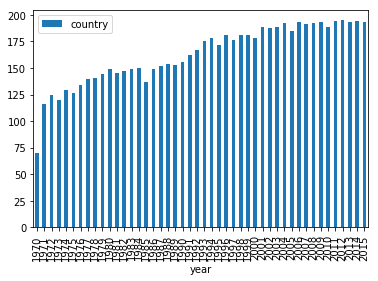

In [5]:
debates[["year", "country"]].groupby("year").count().plot(kind="bar")

It seems like more an more countries are speakers at the General Debates each year, from 1970 (70 countries) to at least 2006 (193 countries).
This is explained, at first by the end of series of decolonization in the 70s and 80s (more countries break of from their empires to become independent countries), then by the break-up of the Soviet Union after 1989.

In [6]:
## Text Preparation

Some special characters are not recognized (wrong encoding), which would prevent further analysis, so let's remove them.

In [7]:
debates['text'] = debates['text'].str.decode(encoding='ascii',errors='ignore')

Now let's transform the text to lists

In [8]:
debates['token'] = debates['text'].apply(word_tokenize)

I want to find out which countries speakers mention, and will show trends in time, as well as  look at whether certain countries speak more about specific other countries. List found [here](http://www.nationsonline.org/oneworld/country_code_list.htm), and tweaked here and there for better results.

In [9]:
IPython.load_extensions('usability/hide_input/main');
countries = {
    'AFG': 'Afghanistan', 
    'ALA': 'Aland Islands', 
    'ALB': 'Albania', 
    'DZA': 'Algeria', 
    'ASM': 'American Samoa', 
    'AND': 'Andorra', 
    'AGO': 'Angola', 
    'AIA': 'Anguilla', 
    'ATA': 'Antarctica', 
    'ATG': 'Antigua and Barbuda', 
    'ARG': 'Argentina', 
    'ARM': 'Armenia', 
    'ABW': 'Aruba', 
    'AUS': 'Australia', 
    'AUT': 'Austria', 
    'AZE': 'Azerbaijan', 
    'BHS': 'Bahamas', 
    'BHR': 'Bahrain', 
    'BGD': 'Bangladesh', 
    'BRB': 'Barbados', 
    'BLR': 'Belarus', 
    'BEL': 'Belgium', 
    'BLZ': 'Belize', 
    'BEN': 'Benin', 
    'BMU': 'Bermuda', 
    'BTN': 'Bhutan', 
    'BOL': 'Bolivia', 
    'BIH': 'Bosnia and Herzegovina', 
    'BWA': 'Botswana', 
    'BVT': 'Bouvet Island', 
    'BRA': 'Brazil', 
    'VGB': 'British Virgin Islands', 
    'IOT': 'British Indian Ocean Territory', 
    'BRN': 'Brunei', 
    'BGR': 'Bulgaria', 
    'BFA': 'Burkina Faso', 
    'BDI': 'Burundi', 
    'KHM': 'Cambodia', 
    'CMR': 'Cameroon', 
    'CAN': 'Canada', 
    'CPV': 'Cape Verde', 
    'CYM': 'Cayman Islands', 
    'CAF': 'Central African Republic', 
    'TCD': 'Chad', 
    'CHL': 'Chile', 
    'CHN': 'China', 
    'HKG': 'Hong Kong', 
    'MAC': 'Macao, SAR China', 
    'CXR': 'Christmas Island', 
    'CCK': 'Cocos Islands', 
    'COL': 'Colombia', 
    'COM': 'Comoros', 
    'COG': 'Congo', 
    'COD': 'Democratic Republic of Congo', 
    'COK': 'Cook Islands', 
    'CRI': 'Costa Rica', 
    'CIV': "Côte d'Ivoire", 
    'HRV': 'Croatia', 
    'CUB': 'Cuba', 
    'CYP': 'Cyprus', 
    'CZE': 'Czech Republic', 
    'DNK': 'Denmark', 
    'DJI': 'Djibouti', 
    'DMA': 'Dominica', 
    'DOM': 'Dominican Republic', 
    'ECU': 'Ecuador', 
    'EGY': 'Egypt', 
    'SLV': 'El Salvador', 
    'GNQ': 'Equatorial Guinea', 
    'ERI': 'Eritrea', 
    'EST': 'Estonia', 
    'ETH': 'Ethiopia', 
    'FLK': 'Falkland Islands', 
    'FRO': 'Faroe Islands', 
    'FJI': 'Fiji', 
    'FIN': 'Finland', 
    'FRA': 'France', 
    'GUF': 'French Guiana', 
    'PYF': 'French Polynesia', 
    'ATF': 'French Southern Territories', 
    'GAB': 'Gabon', 
    'GMB': 'Gambia', 
    'GEO': 'Georgia', 
    'DEU': 'Germany', 
    'GHA': 'Ghana', 
    'GIB': 'Gibraltar', 
    'GRC': 'Greece', 
    'GRL': 'Greenland', 
    'GRD': 'Grenada', 
    'GLP': 'Guadeloupe', 
    'GUM': 'Guam', 
    'GTM': 'Guatemala', 
    'GGY': 'Guernsey', 
    'GIN': 'Guinea', 
    'GNB': 'Guinea-Bissau', 
    'GUY': 'Guyana', 
    'HTI': 'Haiti', 
    'HMD': 'Heard and Mcdonald Islands', 
    'VAT': 'Vatican', 
    'HND': 'Honduras', 
    'HUN': 'Hungary', 
    'ISL': 'Iceland', 
    'IND': 'India', 
    'IDN': 'Indonesia', 
    'IRN': 'Iran', 
    'IRQ': 'Iraq', 
    'IRL': 'Ireland', 
    'IMN': 'Isle of Man', 
    'ISR': 'Israel', 
    'ITA': 'Italy', 
    'JAM': 'Jamaica', 
    'JPN': 'Japan', 
    'JEY': 'Jersey', 
    'JOR': 'Jordan', 
    'KAZ': 'Kazakhstan', 
    'KEN': 'Kenya', 
    'KIR': 'Kiribati', 
    'PRK': 'North Korea', 
    'KOR': 'South Korea', 
    'KWT': 'Kuwait', 
    'KGZ': 'Kyrgyzstan', 
    'LAO': 'Lao', 
    'LVA': 'Latvia', 
    'LBN': 'Lebanon', 
    'LSO': 'Lesotho', 
    'LBR': 'Liberia', 
    'LBY': 'Libya', 
    'LIE': 'Liechtenstein', 
    'LTU': 'Lithuania', 
    'LUX': 'Luxembourg', 
    'MKD': 'Macedonia', 
    'MDG': 'Madagascar', 
    'MWI': 'Malawi', 
    'MYS': 'Malaysia', 
    'MDV': 'Maldives', 
    'MLI': 'Mali', 
    'MLT': 'Malta', 
    'MHL': 'Marshall Islands', 
    'MTQ': 'Martinique', 
    'MRT': 'Mauritania', 
    'MUS': 'Mauritius', 
    'MYT': 'Mayotte', 
    'MEX': 'Mexico', 
    'FSM': 'Micronesia', 
    'MDA': 'Moldova', 
    'MCO': 'Monaco', 
    'MNG': 'Mongolia', 
    'MNE': 'Montenegro', 
    'MSR': 'Montserrat', 
    'MAR': 'Morocco', 
    'MOZ': 'Mozambique', 
    'MMR': 'Myanmar', 
    'NAM': 'Namibia', 
    'NRU': 'Nauru', 
    'NPL': 'Nepal', 
    'NLD': 'Netherlands', 
    'ANT': 'Netherlands Antilles', 
    'NCL': 'New Caledonia', 
    'NZL': 'New Zealand', 
    'NIC': 'Nicaragua', 
    'NER': 'Niger', 
    'NGA': 'Nigeria', 
    'NIU': 'Niue', 
    'NFK': 'Norfolk Island', 
    'MNP': 'Northern Mariana Islands', 
    'NOR': 'Norway', 
    'OMN': 'Oman', 
    'PAK': 'Pakistan', 
    'PLW': 'Palau', 
    'PSE': 'Palestine', 
    'PAN': 'Panama', 
    'PNG': 'Papua New Guinea', 
    'PRY': 'Paraguay', 
    'PER': 'Peru', 
    'PHL': 'Philippines', 
    'PCN': 'Pitcairn', 
    'POL': 'Poland', 
    'PRT': 'Portugal', 
    'PRI': 'Puerto Rico', 
    'QAT': 'Qatar', 
    'REU': 'Réunion', 
    'ROU': 'Romania', 
    'RUS': 'Russia', 
    'RWA': 'Rwanda', 
    'BLM': 'Saint-Barthélemy', 
    'SHN': 'Saint Helena', 
    'KNA': 'Saint Kitts and Nevis', 
    'LCA': 'Saint Lucia', 
    'MAF': 'Saint-Martin', 
    'SPM': 'Saint Pierre and Miquelon', 
    'VCT': 'Saint Vincent and Grenadines', 
    'WSM': 'Samoa', 
    'SMR': 'San Marino', 
    'STP': 'Sao Tome and Principe', 
    'SAU': 'Saudi Arabia', 
    'SEN': 'Senegal', 
    'SRB': 'Serbia', 
    'SYC': 'Seychelles', 
    'SLE': 'Sierra Leone', 
    'SGP': 'Singapore', 
    'SVK': 'Slovakia', 
    'SVN': 'Slovenia', 
    'SLB': 'Solomon Islands', 
    'SOM': 'Somalia', 
    'ZAF': 'South Africa', 
    'SGS': 'South Georgia and the South Sandwich Islands', 
    'SSD': 'South Sudan', 
    'ESP': 'Spain', 
    'LKA': 'Sri Lanka', 
    'SDN': 'Sudan', 
    'SUR': 'Suriname', 
    'SJM': 'Svalbard and Jan Mayen Islands', 
    'SWZ': 'Swaziland', 
    'SWE': 'Sweden', 
    'CHE': 'Switzerland', 
    'SYR': 'Syria', 
    'TWN': 'Taiwan', 
    'TJK': 'Tajikistan', 
    'TZA': 'Tanzania', 
    'THA': 'Thailand', 
    'TLS': 'Timor-Leste', 
    'TGO': 'Togo', 
    'TKL': 'Tokelau', 
    'TON': 'Tonga', 
    'TTO': 'Trinidad and Tobago', 
    'TUN': 'Tunisia', 
    'TUR': 'Turkey', 
    'TKM': 'Turkmenistan', 
    'TCA': 'Turks and Caicos Islands', 
    'TUV': 'Tuvalu', 
    'UGA': 'Uganda', 
    'UKR': 'Ukraine', 
    'ARE': 'United Arab Emirates', 
    'GBR': 'United Kingdom', 
    'USA': 'United States of America', 
    'UMI': 'US Minor Outlying Islands', 
    'URY': 'Uruguay', 
    'UZB': 'Uzbekistan', 
    'VUT': 'Vanuatu', 
    'VEN': 'Venezuela', 
    'VNM': 'Viet Nam', 
    'VIR': 'Virgin Islands', 
    'WLF': 'Wallis and Futuna Islands', 
    'ESH': 'Western Sahara', 
    'YEM': 'Yemen', 
    'ZMB': 'Zambia', 
    'ZWE': 'Zimbabwe'
}

NameError: name 'IPython' is not defined

In [ ]:
debates['countries_mentioned'] = debates['token'].apply(lambda token: {x:token.count(x) for x in token if x.encode('utf8') in countries.values()})

I'll now save this in a table for study and display

In [ ]:
country_mentions = pd.concat([debates[["year", "country"]],
                              debates['countries_mentioned'].apply(pd.Series)], axis=1).dropna(axis=1, how='all')
country_mentions['country'] = country_mentions['country'].apply(lambda x: countries.get(x))
country_mentions.head()

In [ ]:
import plotly.plotly as py
import plotly.figure_factory as ff

table = ff.create_table(country_mentions)
py.iplot(table, filename='table')

This table is a little too long and large to make sense out of it. Let's group it by year to extract the trend, and by country to get the speaking country info.

In [ ]:
#country_mentions_by_year = country_mentions.groupby(country_mentions.columns[2:])['year'].sum()
country_mentions_by_country = country_mentions.groupby("country")[[country_mentions.columns[2:]]].sum()
country_mentions_by_country

We need to remove the punctuation and english stopwords to only keep the essence of the text.

In [ ]:
stop_words = set(stopwords.words('english'))
debates['clean'] = debates['token'].apply(lambda x: [w for w in x if not w in stop_words and not w in punctuation])

Let's extract the entities (organizations, persons, etc.) speakers are referring to.

In [ ]:
debates['entities'] = debates['clean'].apply(lambda x: nltk.ne_chunk(nltk.pos_tag(x), binary=False))

In [ ]:
debates['entities'][0].draw()

In [ ]:
#nltk.ne_chunk(nltk.pos_tag(debates['clean'][0]), binary=False).draw()

tagged = nltk.pos_tag(debates['clean'][0])
namedEnt = nltk.ne_chunk(tagged, binary=False)
namedEnt.draw()

In [ ]:
namedEnt